In [17]:
import numpy, seaborn, pandas
import scipy.stats as stats
from scipy.stats import gaussian_kde
import matplotlib, matplotlib.pyplot as plt

import re #to search

In [18]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [19]:
file_directory = "/Users/kja11/OneDrive - Menntaský (1)/Mild_Hypothermia_project/in_silico/Python/"

input_path = "1) input/flow_cytometry/"
output_path = "3) output/flow_cytometry/"

# Data download and modifications

## Meta and statitics data

In [20]:
experiment = 'ribosome experiment n°2'

In [21]:
# Meta data, important for sample_name
df_meta = pandas.read_csv(file_directory + input_path + 'ribosome_rbm3_sp1_flowjo_exp2_table.csv', sep = ',')

# Interested in name and Mode (the most frequently occurring value)
df_meta = df_meta.rename(columns = {'Unnamed: 0' : 'sample_name',
                                    'HEK293/Single Cells | Count' : 'count',
                                    'HEK293/Single Cells | Geometric Mean (PE-CF594-A)' : 'gMFI'})
print(df_meta.shape, '\n')
df_meta.tail(5)

(17, 3) 



,sample_name,count,gMFI
12,Samples_mCherry sp1 rpl6b 32.fcs,31245,13072
13,Samples_mCherry sp1 rpl6b 37.fcs,38696,12578
14,Samples_mcheery RBM3 ctl 37.fcs,34406,2383
15,Mean,29515,6634
16,SD,8877,5146


In [22]:
# remove the last rows
df_meta = df_meta[(df_meta['sample_name'] != 'Mean') & (df_meta['sample_name'] != 'SD')]
df_meta.tail()

,sample_name,count,gMFI
10,Samples_mCherry sp1 rpl6a 32.fcs,29069,13637
11,Samples_mCherry sp1 rpl6a 37.fcs,35915,12468
12,Samples_mCherry sp1 rpl6b 32.fcs,31245,13072
13,Samples_mCherry sp1 rpl6b 37.fcs,38696,12578
14,Samples_mcheery RBM3 ctl 37.fcs,34406,2383


In [23]:
# Have to rename the samples to have clear labelling  
sample_name = df_meta.sample_name

# select the three meta info
df_meta['Temperature'] = sample_name.apply(lambda x: re.search(r'\b(32|37)\b', x).group()
                                           if re.search(r'\b(32|37)\b', x) 
                                           else None)

df_meta['mhi-target'] = sample_name.apply(lambda x: re.search(r'(rbm3|sp1|cirbp)', x, re.IGNORECASE).group().lower()
                                           if re.search(r'(rbm3|sp1|cirbp)', x, re.IGNORECASE) 
                                           else None)

df_meta['condition'] = sample_name.apply(lambda x: re.search(r'(Unstained|ctl|rpl6a|rpl6b|rpl40)', x, re.IGNORECASE).group().lower()
                                          if re.search(r'(Unstained|ctl|rpl6a|rpl6b|rpl40)', x, re.IGNORECASE) 
                                          else None)

df_meta.loc[df_meta['condition'] == 'unstained', ['mhi-target', 'Temperature']] = ['HEK293', 'control']

df_meta

,sample_name,count,gMFI,Temperature,mhi-target,condition
0,Samples_Unstained.fcs,26404,110,control,HEK293,unstained
1,Samples_mCherry RBM3 RPL6A 32.fcs,31793,3152,32,rbm3,rpl6a
2,Samples_mCherry RBM3 RPL6A 37.fcs,35592,3065,37,rbm3,rpl6a
3,Samples_mCherry RBM3 RPL6B 32.fcs,32408,3276,32,rbm3,rpl6b
4,Samples_mCherry RBM3 RPL6B 37.fcs,38095,2954,37,rbm3,rpl6b
5,Samples_mCherry RBM3 RPL40 32.fcs,30162,3409,32,rbm3,rpl40
6,Samples_mCherry RBM3 RPL40 37.fcs,2091,2326,37,rbm3,rpl40
7,Samples_mCherry SP1 ctl 32.fcs,27356,13534,32,sp1,ctl
8,Samples_mCherry rbm3 ctl 32.fcs,27433,3312,32,rbm3,ctl
9,Samples_mCherry sp1 ctl 37.fcs,22061,10239,37,sp1,ctl


In [24]:
label_serie = df_meta[['mhi-target', 'condition', 'Temperature']].agg('_'.join, axis=1)
df_meta.insert(0, "label", label_serie)
df_meta.head()

,label,sample_name,count,gMFI,Temperature,mhi-target,condition
0,HEK293_unstained_control,Samples_Unstained.fcs,26404,110,control,HEK293,unstained
1,rbm3_rpl6a_32,Samples_mCherry RBM3 RPL6A 32.fcs,31793,3152,32,rbm3,rpl6a
2,rbm3_rpl6a_37,Samples_mCherry RBM3 RPL6A 37.fcs,35592,3065,37,rbm3,rpl6a
3,rbm3_rpl6b_32,Samples_mCherry RBM3 RPL6B 32.fcs,32408,3276,32,rbm3,rpl6b
4,rbm3_rpl6b_37,Samples_mCherry RBM3 RPL6B 37.fcs,38095,2954,37,rbm3,rpl6b


In [25]:
# Calculate Geometric mean fluorescence ratio
gMFI_control = df_meta[df_meta.label == 'HEK293_unstained_control']['gMFI'].iloc[0]
df_meta = df_meta.assign(gMFI_ratio = (df_meta.gMFI/gMFI_control))

# Add SampleID to merge with the flow data
df_meta['SampleID'] = ''
df_meta['SampleID'] = range(1, len(df_meta) + 1)
df_meta = df_meta[['label','SampleID', 'gMFI_ratio']]
df_meta.head()

,label,SampleID,gMFI_ratio
0,HEK293_unstained_control,1,1.000000
1,rbm3_rpl6a_32,2,28.654545
2,rbm3_rpl6a_37,3,27.863636
3,rbm3_rpl6b_32,4,29.781818
4,rbm3_rpl6b_37,5,26.854545


## Flow data

In [26]:
#data Flow Cytometry
df = pandas.read_csv(file_directory + input_path + 'ribosome_rbm3_sp1_flowjo_exp2.csv', sep = ',')

# What channel for mCherry ? For this exepriemnent PE-CY7 for CIRBP ; PE-CF594 for RBM3 & SP1
df = df.rename(columns = {'PE-CF594-A' : 'mCherry-A'})

print(df.shape, '\n')
df

(442726, 12) 



,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,PE-A,mCherry-A,PE-Cy5-A,PE-Cy7-A,Time,SampleID
0,62295.4,32384.3,144282.0,29675.9,21099.1,92991.2,88.5062,77.5324,75.2865,118.7710,0.030845,1
1,68085.5,38850.8,165748.0,47785.5,32037.7,113278.0,35.4339,112.8040,53.0315,148.8140,0.032265,1
2,68089.3,34438.6,157964.0,58353.7,37813.9,109504.0,66.1386,123.6490,173.0900,124.0100,0.032632,1
3,108288.0,66650.9,152546.0,40765.6,28259.6,97934.6,80.3233,101.8770,69.0905,92.3209,0.034947,1
4,53583.2,32323.4,148347.0,33142.1,24911.1,94118.6,109.4850,184.1770,50.3856,56.4774,0.035610,1
...,...,...,...,...,...,...,...,...,...,...,...,...
442721,56535.9,38314.7,144244.0,28614.8,20836.5,93670.9,779.4000,1417.3700,952.4970,632.8950,40.019700,15
442722,72644.8,42429.8,161989.0,45155.8,28505.4,113778.0,935.3610,1620.6900,1163.6300,666.6840,40.020100,15
442723,76669.1,44862.9,152986.0,34337.6,23963.5,106519.0,3396.5200,5688.2900,4120.6400,2605.5500,40.020700,15
442724,119630.0,67631.1,154909.0,34435.6,25898.7,94154.5,6518.4100,12382.5000,7529.3200,3182.6700,40.021300,15


In [27]:
print(f'Amount of SampleID: {df.SampleID.max()-1}')
print(f'Amount of meta-info label: {len(df_meta.label.unique())}')

Amount of SampleID: 14
Amount of meta-info label: 15


## Merge

In [28]:
# merge 
df = df_meta.merge(df)
df = df.drop(['SampleID', 'Time'], axis=1)
df

,label,gMFI_ratio,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,PE-A,mCherry-A,PE-Cy5-A,PE-Cy7-A
0,HEK293_unstained_control,1.000000,62295.4,32384.3,144282.0,29675.9,21099.1,92991.2,88.5062,77.5324,75.2865,118.7710
1,HEK293_unstained_control,1.000000,68085.5,38850.8,165748.0,47785.5,32037.7,113278.0,35.4339,112.8040,53.0315,148.8140
2,HEK293_unstained_control,1.000000,68089.3,34438.6,157964.0,58353.7,37813.9,109504.0,66.1386,123.6490,173.0900,124.0100
3,HEK293_unstained_control,1.000000,108288.0,66650.9,152546.0,40765.6,28259.6,97934.6,80.3233,101.8770,69.0905,92.3209
4,HEK293_unstained_control,1.000000,53583.2,32323.4,148347.0,33142.1,24911.1,94118.6,109.4850,184.1770,50.3856,56.4774
...,...,...,...,...,...,...,...,...,...,...,...,...
442721,rbm3_ctl_37,21.663636,56535.9,38314.7,144244.0,28614.8,20836.5,93670.9,779.4000,1417.3700,952.4970,632.8950
442722,rbm3_ctl_37,21.663636,72644.8,42429.8,161989.0,45155.8,28505.4,113778.0,935.3610,1620.6900,1163.6300,666.6840
442723,rbm3_ctl_37,21.663636,76669.1,44862.9,152986.0,34337.6,23963.5,106519.0,3396.5200,5688.2900,4120.6400,2605.5500
442724,rbm3_ctl_37,21.663636,119630.0,67631.1,154909.0,34435.6,25898.7,94154.5,6518.4100,12382.5000,7529.3200,3182.6700


In [29]:
df.label.unique()

array(['HEK293_unstained_control', 'rbm3_rpl6a_32', 'rbm3_rpl6a_37',
       'rbm3_rpl6b_32', 'rbm3_rpl6b_37', 'rbm3_rpl40_32', 'rbm3_rpl40_37',
       'sp1_ctl_32', 'rbm3_ctl_32', 'sp1_ctl_37', 'sp1_rpl6a_32',
       'sp1_rpl6a_37', 'sp1_rpl6b_32', 'sp1_rpl6b_37', 'rbm3_ctl_37'],
      dtype=object)

# Graphics

In [30]:
# Define a function to process data and calculate KDE
def process_and_plot(sample_data, color, label):
    data = sample_data['mCherry-A'].apply(numpy.log10)
    data = data[numpy.isfinite(data)] #not have infinte or nan
    
    # perform Kernel Density Estimation
    kde = gaussian_kde(data)
    x = numpy.linspace(min(data), max(data), 1000)
    y = kde(x)
    
    # normalize to have y from 0 to 100
    peak_y = numpy.max(y)
    normalized_y = (y / peak_y) * 100
    
    # find Mode
    mode_index = numpy.argmax(y)
    mode_value = x[mode_index]

    # Plot 
    plt.plot(x, normalized_y, color=color, alpha=0.7, label=f'{label}; {MHI.upper()}-MHI si{condition.upper()}' if label.startswith('3') else f'{label}')
    plt.fill_between(x, normalized_y, color=color, alpha=0.3) # fill the curve
    plt.axvline(mode_value, color=color, linestyle='--') # add vertical line 
    plt.xlim(0, 6.5)
    
    return mode_value # return to see if one sample is missing 

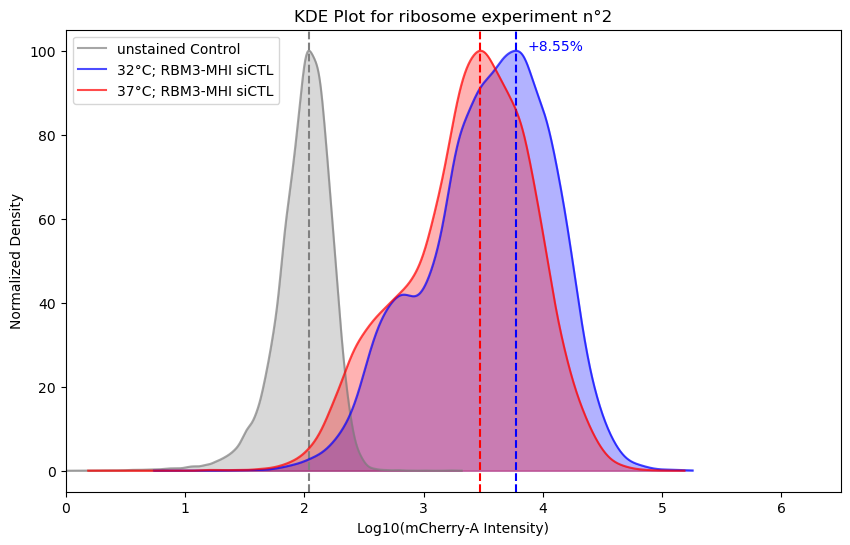

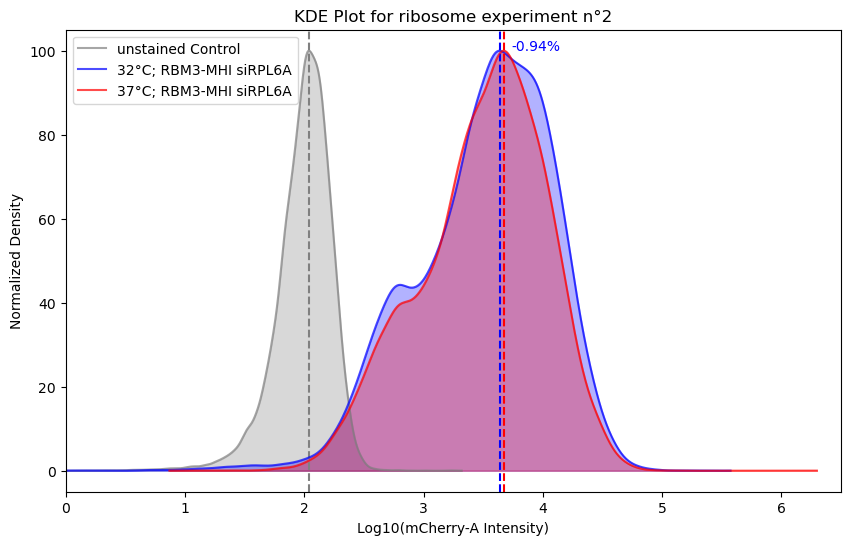

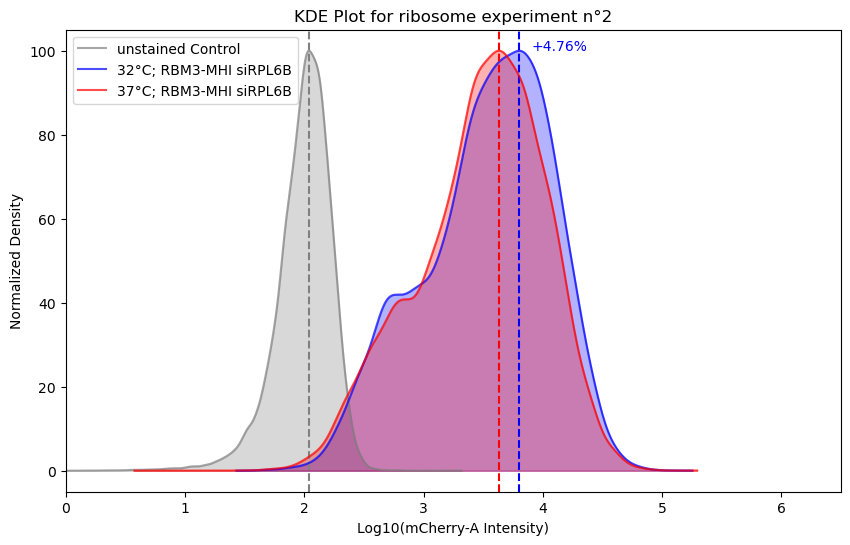

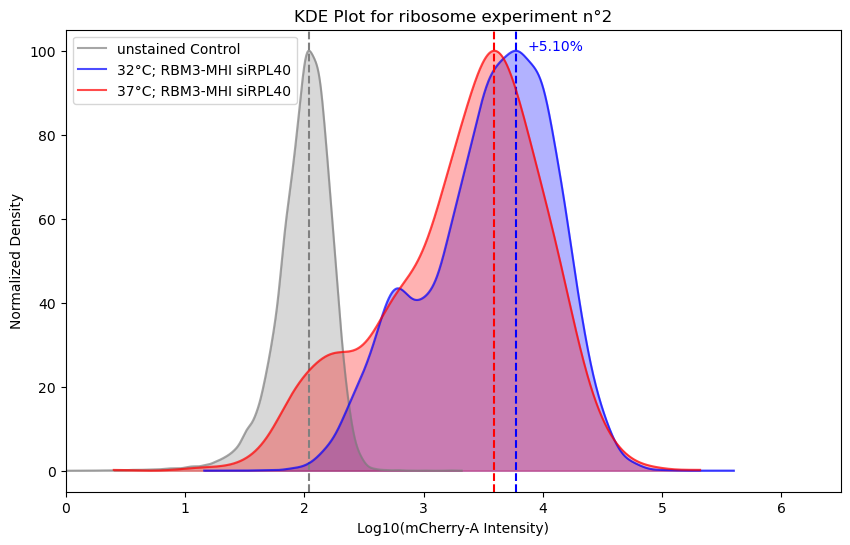

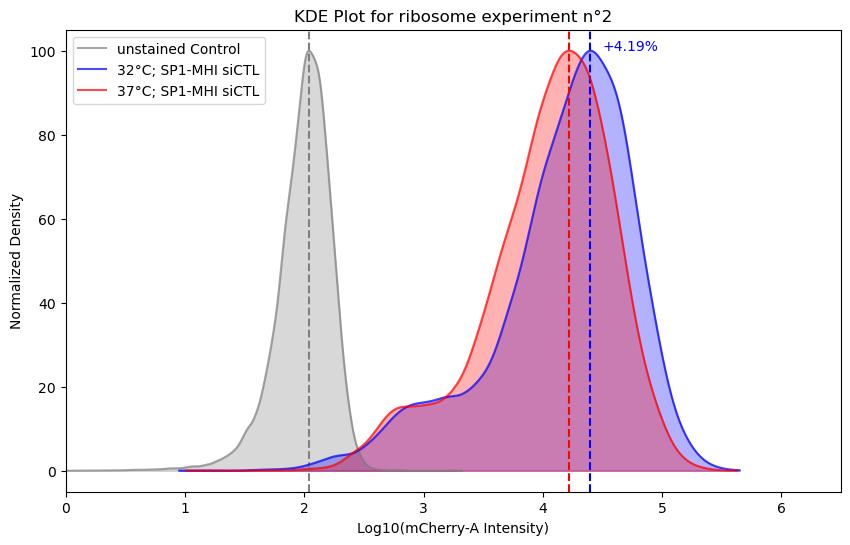

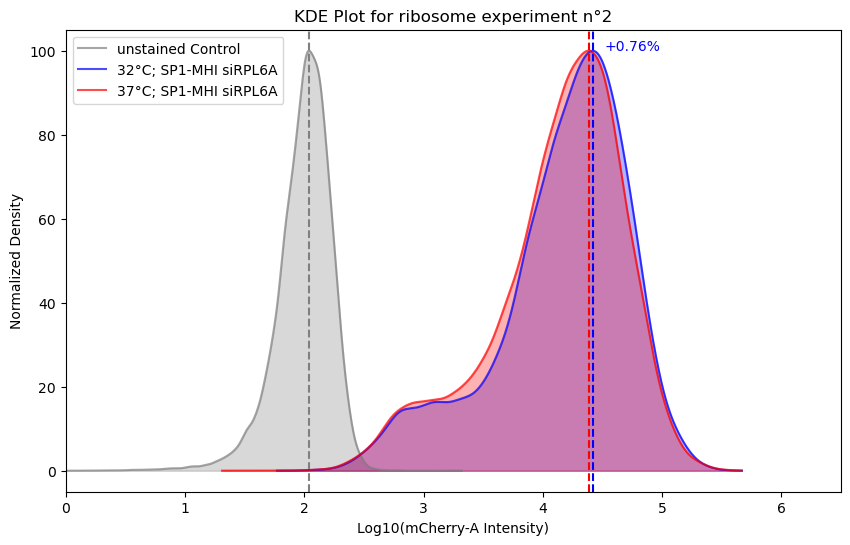

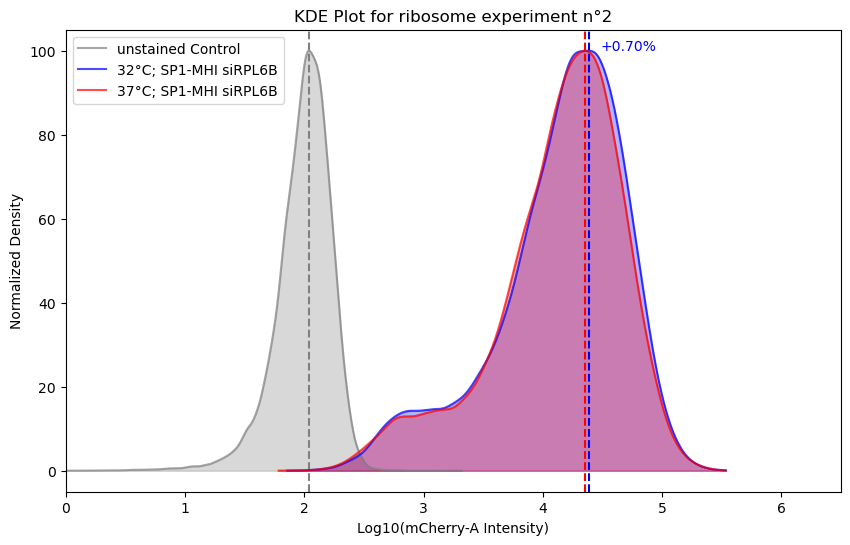

Missing samples are: ['sp1_rpl40_32', 'cirbp_ctl_32', 'cirbp_rpl6a_32', 'cirbp_rpl6b_32', 'cirbp_rpl40_32']


In [31]:
# Define parameters
unstained_control = 'HEK293_unstained_control'
temperatures = [32, 37]
MHIs = ['rbm3', 'sp1', 'cirbp']
conditions = ['ctl', 'rpl6a', 'rpl6b', 'rpl40']

# Loop over MHIs and conditions
missing_samples_l = []

for MHI in MHIs:
    for condition in conditions:
        fig = plt.figure(figsize=(10, 6))

        # Plot the Unstained control
        sample_control = df[df['label'] == unstained_control]
        process_and_plot(sample_control, 'gray', 'unstained Control')
        
        mode_32 = None
        mode_37 = None
        missing_sample = False
        
        for temp, color in zip(temperatures, ['blue', 'red']):
            label = f'{MHI}_{condition}_{temp}'
            sample = df[df['label'] == label]
            
            # if one sample is missing, stop
            if sample.empty:
                missing_samples_l.append(label)
                missing_sample = True
                break 
            
            # save mode value to calculate % later
            mode_value = process_and_plot(sample, color, f'{temp}°C')
            if temp == 32:
                mode_32 = mode_value
            elif temp == 37:
                mode_37 = mode_value
                
        # Close the plot if any sample is missing        
        if missing_sample:
            plt.close(fig)  
            continue
                
        # Calculate and annotate percentage change if both modes are available
        if mode_32 is not None and mode_37 is not None:
            percent_change = ((mode_32 - mode_37) / mode_37) * 100
            plt.text(mode_32 + 0.1, 100, f'{percent_change:+.2f}%', color='blue', fontsize=10)

        # Add labels and legend
        plt.xlabel('Log10(mCherry-A Intensity)')
        plt.ylabel('Normalized Density')
        plt.title(f'KDE Plot for {experiment}')
        plt.legend(loc='upper left')

        # Save the graph
        filename = f'{MHI}_{condition}_KDE_plot.png'
        # plt.savefig(filename)
        plt.show()
        plt.close(fig)

#print missing samples   
print(f'Missing samples are: {missing_samples_l}')

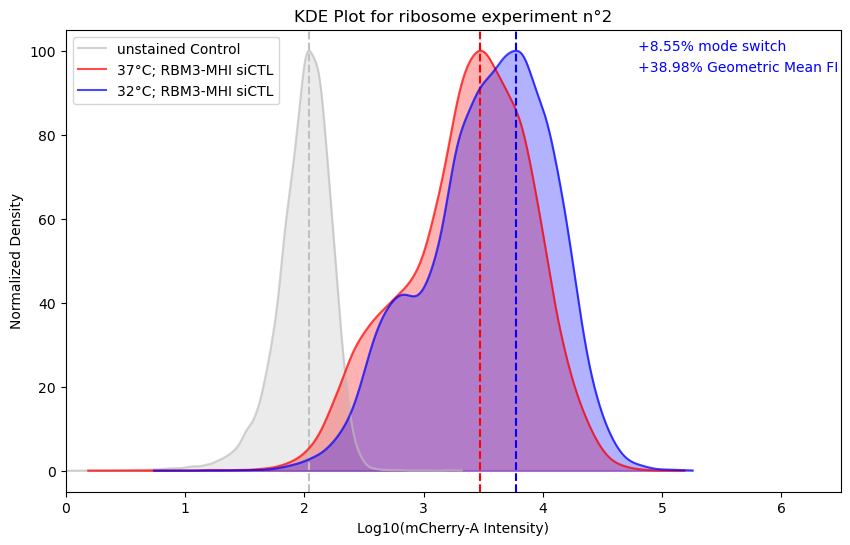

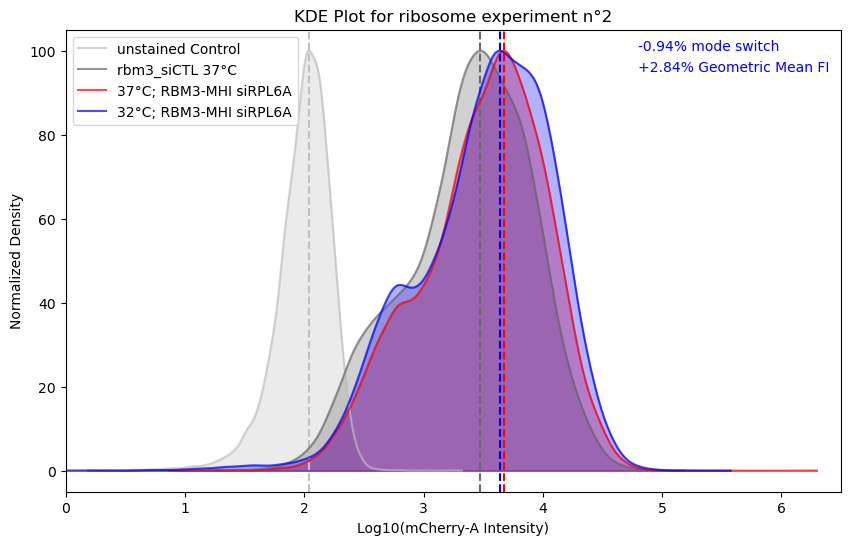

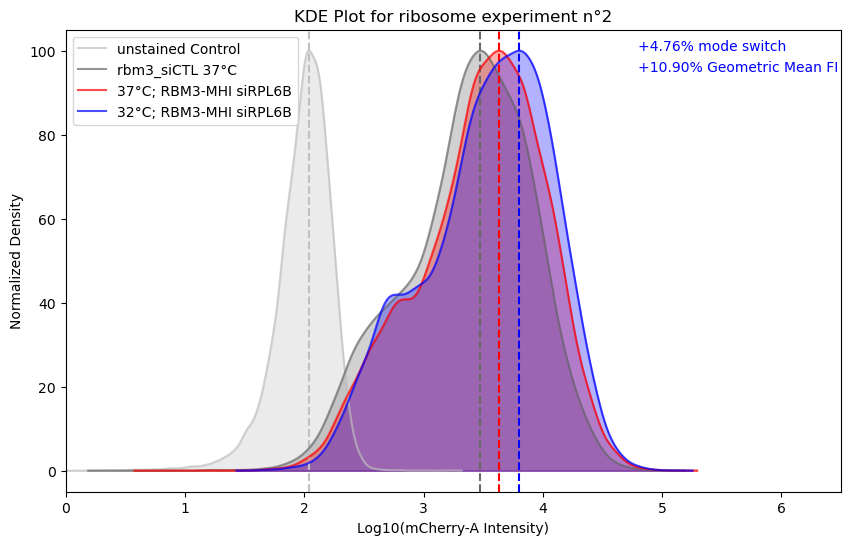

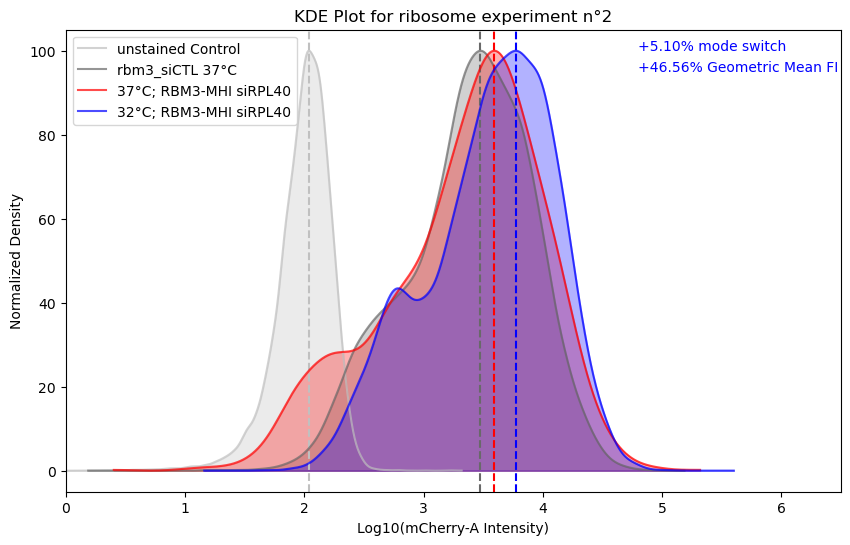

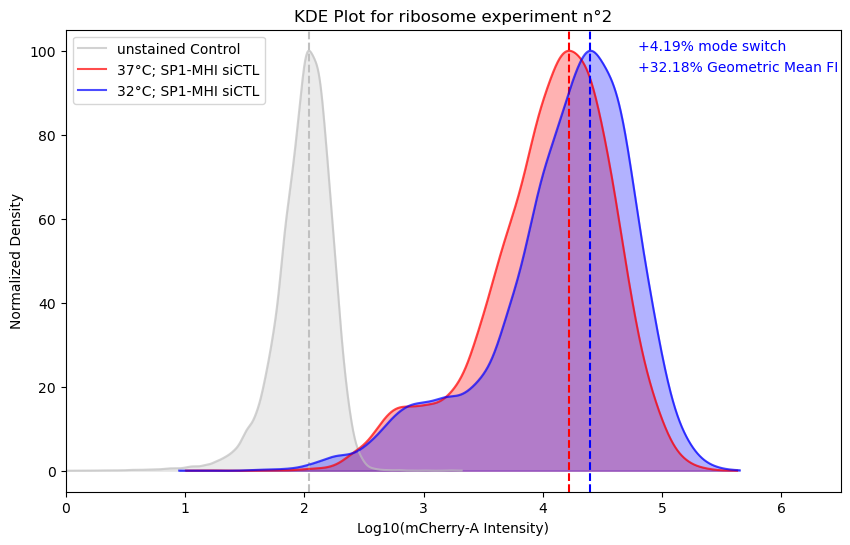

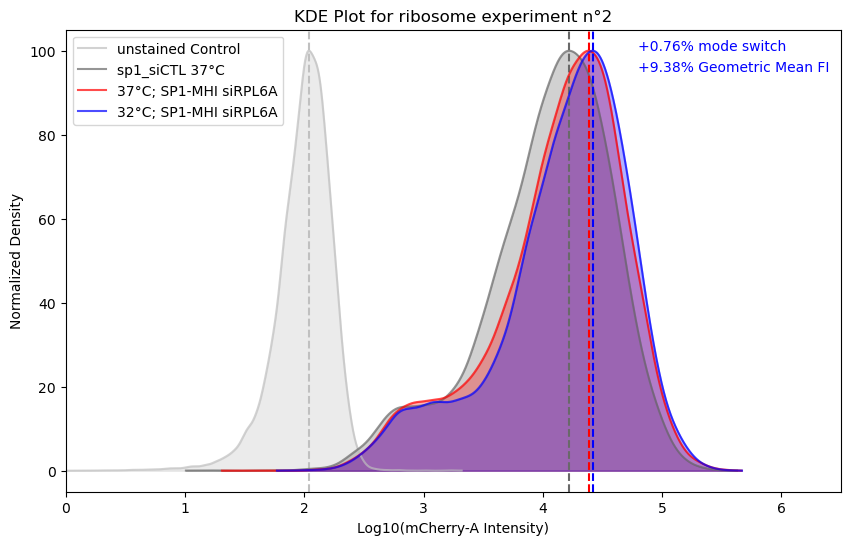

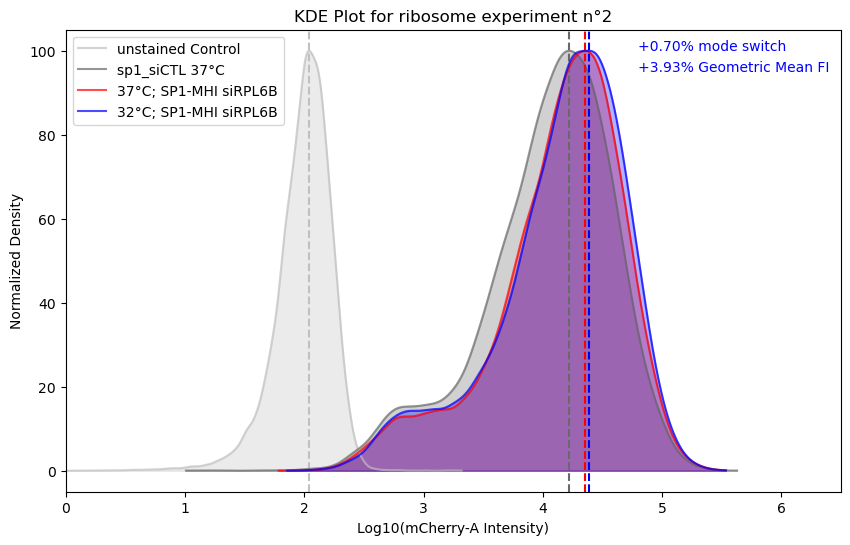

Missing samples are: ['sp1_rpl40_37']


In [34]:
# Define parameters
unstained_control = 'HEK293_unstained_control'
temperatures = [37, 32]
MHIs = ['rbm3', 'sp1']
conditions = ['ctl', 'rpl6a', 'rpl6b', 'rpl40']

# Loop over MHIs and conditions
missing_samples_l = []

for MHI in MHIs:
    for condition in conditions:
        fig = plt.figure(figsize=(10, 6))

        # Plot the Unstained control
        sample_control = df[df['label'] == unstained_control]
        process_and_plot(sample_control, 'silver', 'unstained Control')
        
        # Plot condition_ctl_37
        if condition != 'ctl':
            sample_ctl_37 = df[df['label'] == f'{MHI}_ctl_37']
            process_and_plot(sample_ctl_37, 'dimgray', f'{MHI}_siCTL 37°C')      
              
        mode_32 = None
        mode_37 = None
        gMFI_32 = None
        gMFI_37 = None
        missing_sample = False
        
        for temp, color in zip(temperatures, ['red', 'blue']):
            label = f'{MHI}_{condition}_{temp}'
            sample = df[df['label'] == label]
            
            # if one sample is missing, stop
            if sample.empty:
                missing_samples_l.append(label)
                missing_sample = True
                break 
            
            # save mode value & gMFI value to calculate % later
            mode_value = process_and_plot(sample, color, f'{temp}°C')
            if temp == 32:
                mode_32 = mode_value
                gMFI_32 = df[df['label'] == label]['gMFI_ratio'].iloc[0]
            elif temp == 37:
                mode_37 = mode_value
                gMFI_37 = df[df['label'] == label]['gMFI_ratio'].iloc[0]
                
        # Close the plot if any sample is missing        
        if missing_sample:
            plt.close(fig)  
            continue
                
        # Calculate and annotate percentage change if both are available
        if mode_32 is not None and mode_37 is not None:
            mode_percent_change = ((mode_32 - mode_37) / mode_37) * 100
            plt.text(4.8, 100, f'{mode_percent_change:+.2f}% mode switch', color='blue', fontsize=10)

            mfi_percent_change = ((gMFI_32 - gMFI_37) / gMFI_37) * 100
            plt.text(4.8, 95, f'{mfi_percent_change:+.2f}% Geometric Mean FI', color='blue', fontsize=10)

        # Add labels and legend
        plt.xlabel('Log10(mCherry-A Intensity)')
        plt.ylabel('Normalized Density')
        plt.title(f'KDE Plot for {experiment}')
        plt.legend(loc='upper left')

        # Save the graph
        filename = f'{MHI}_{condition}_KDE_plot.png'
#         plt.savefig(filename)
        plt.show()
        plt.close(fig)

#print missing samples   
print(f'Missing samples are: {missing_samples_l}')